В работе использовались открытые данные приложения к книге _An Introduction to Statistical Learning with Applications in R_ by _Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani_: [Туц](http://www-bcf.usc.edu/~gareth/ISL/data.html).

## Градиентный спуск
Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Stochastic Gradient Descent (SGD)
Проблема градиентного спуска, описанного выше, в том, что на больших выборках считать на каждом шаге градиент по всем имеющимся данным может быть очень вычислительно сложно. 
В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

**Загружаем информацию из файла advertising.csv**

In [2]:
adver_data = pd.read_csv('advertising.csv')

**Смотрим на первые 5 записей и на статистику признаков в этом наборе данных.**

In [3]:
adver_data.head()

,TV,Radio,Newspaper,Sales,Unnamed: 4
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


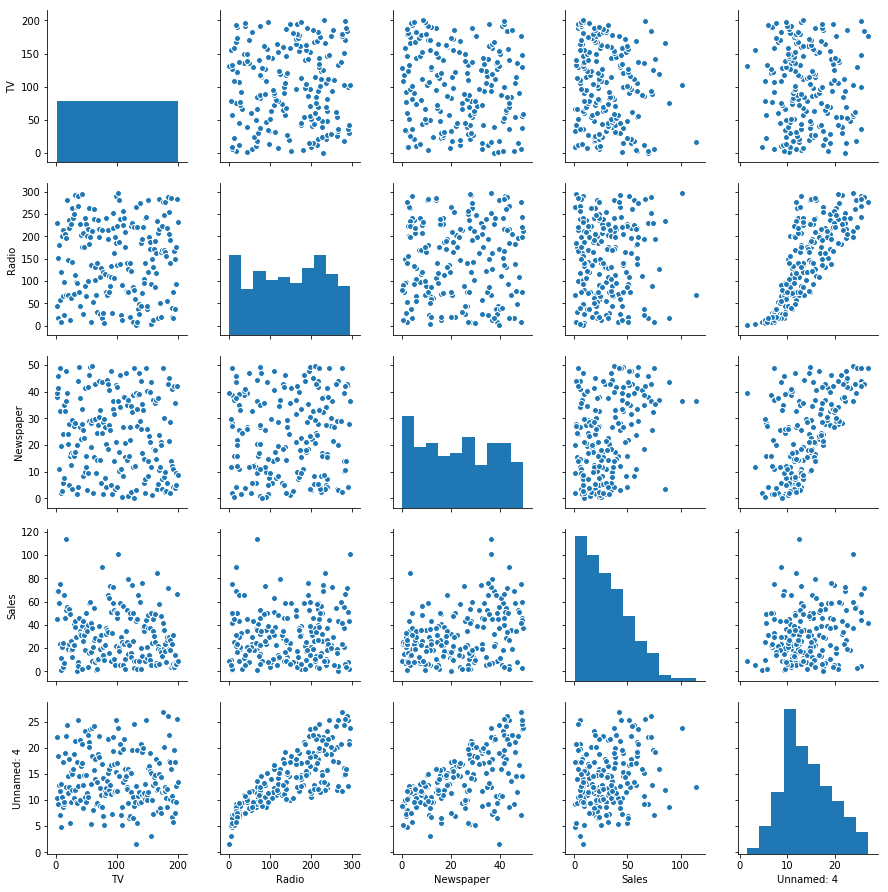

In [4]:
sns.pairplot(adver_data)

**Создаём массивы NumPy *X* из столбцов TV, Radio и Newspaper и *y* - из столбца Sales.**

In [5]:
X = adver_data[['TV', 'Radio', 'Newspaper']]
y = adver_data.Sales

**Масштабируем столбцы матрицы X, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [6]:
# арифметическое среднее
means = X.apply(np.mean)

# стандартное отклонение
stds = X.apply(np.std)

In [7]:
X = X.apply(lambda x: (x - means) / stds, axis = 1)

In [8]:
X.apply(np.mean)
X.apply(np.std)

TV           1.0
Radio        1.0
Newspaper    1.0
dtype: float64

**Добавляем столбец из единиц, дабы не обрабатывать коэффициент линейной регрессии отдельно**

In [9]:
X['x0'] = 1
X = X[['x0', 'TV', 'Radio', 'Newspaper']]
X.head()

,x0,TV,Radio,Newspaper
0,1,-1.723412,0.969852,0.981522
1,1,-1.706091,-1.197376,1.082808
2,1,-1.688771,-1.516155,1.528463
3,1,-1.671450,0.052050,1.217855
4,1,-1.654129,0.394182,-0.841614


**Реализуем функцию *mserror* - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series *y* (значения целевого признака) и *y\_pred* (предсказанные значения).**

**Не используем в этой функции циклы - тогда она будет вычислительно неэффективной.**

Функция: $\dfrac{(y - y_{mean})^{2}}{n}$, где $n$ - количество координат вектора

In [10]:
def mserror(y, y_pred):
    return sum(list(map(lambda x1, x2: (x1 - x2) ** 2, y, y_pred))) / len(y)

**Написали функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.**

In [11]:
def linear_prediction(X, w):
    return X.apply(lambda x: np.dot(x, w), axis=1) 

**Написали функцию *stochastic_gradient_step*, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция принимает матрицу *X*, вектора *y* и *w*, число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов, а также число *$\eta$* (eta) - шаг градиентного спуска (по умолчанию *eta*=0.01). Результат - вектор обновленных весов.**

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$

In [23]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    l = len(y)
    x_k = X.values[train_ind]
    y_k = y.values[train_ind]
    
    return w - 2*eta/l*x_k*(np.dot(w, x_k) - y_k)

**Написали функцию *stochastic_gradient_descent*, реализующую стохастический градиентный спуск для линейной регрессии.
Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

**На каждой итерации в вектор (список) записывается текущее значение среднеквадратичной ошибки. Функция возвращает вектор весов $w$, а также вектор (список) ошибок.**

In [13]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        # обновление весов
        new_w = stochastic_gradient_step(X, y, w, random_ind, eta)
        
        iter_num+=1
        weight_dist = np.linalg.norm(new_w - w)
        
        errors.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    print(weight_dist)
    return w, errors

 **Запустили $10^5$ итераций стохастического градиентного спуска. Указали вектор начальных весов *w_init*, состоящий из нулей. Оставили параметры  *eta* и *seed* равными их значениям по умолчанию (*eta*=0.01, *seed*=42).**
 
 Запустили таймер.

In [27]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, np.zeros(4), max_iter = 1e5)
print(stoch_grad_desc_weights)

0.0038612236443904277
[30.72147302 -2.66185828  0.85637146  7.47883746]
CPU times: user 6min 42s, sys: 306 ms, total: 6min 42s
Wall time: 6min 42s


**Построили график ошибки на последних 50 итерациях стохастического градиентного спуска. Видим, что ошибка не обязательно уменьшается на каждой итерации.**

*MSE - mean square error

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

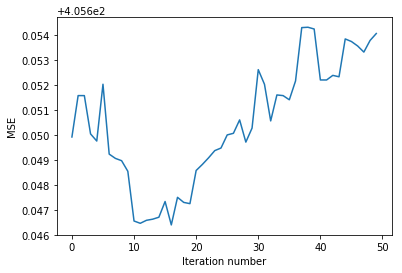

In [28]:
%pylab inline
plot(range(50), stoch_errors_by_iter[-50:])
xlabel('Iteration number')
ylabel('MSE')

**Построили график зависимости ошибки от номера итерации для $10^4$ итераций стохастического градиентного спуска. Видим, что алгоритм сходится.**

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

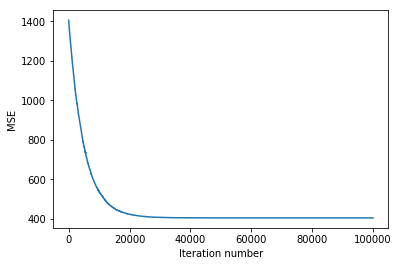

In [29]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Цикличный mini-batch

In [30]:
def mini_batch_step(X, y, w, train_ind, random_ind, eta=0.01):
    l = len(y)
    x_k = [0.0] * train_ind
    y_k = [0.0] * train_ind
    
    for i in range(train_ind - 1):
        x_k[i] = X.values[random_ind[i]]
        y_k[i] = y.values[random_ind[i]]
    
    ans = 0
    for i in range(train_ind - 1):
        ans += 2*eta/l*x_k[i]*(y_k[i] - np.dot(w, x_k[i]))
    
    return w + ans

In [31]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_step(X, y, w, batch_size, random_ind)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        print(weight_dist, min_weight_dist)
        print(iter_num)
        print('\n')
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [32]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)

0.035145932214846805 1e-08
1


0.02828749006603924 1e-08
2


0.04616434544245633 1e-08
3


0.04358161360875631 1e-08
4


0.03033543826313856 1e-08
5


0.03651544693244448 1e-08
6


0.03692376591512675 1e-08
7


0.0681879799808388 1e-08
8


0.030391873347827243 1e-08
9


0.03765564903176164 1e-08
10


0.04978638410377277 1e-08
11


0.030012009317464998 1e-08
12


0.03759649310411794 1e-08
13


0.04537079390671186 1e-08
14


0.023100392767859572 1e-08
15


0.02791576297916331 1e-08
16


0.03756419335191213 1e-08
17


0.03322280596041879 1e-08
18


0.03781220521063367 1e-08
19


0.023538974720504858 1e-08
20


0.0566771374280012 1e-08
21


0.0489286374822643 1e-08
22


0.019801856849659297 1e-08
23


0.034566830133017076 1e-08
24


0.03700233973780177 1e-08
25


0.028633584609616805 1e-08
26


0.03916947527761358 1e-08
27


0.038360099047311795 1e-08
28


0.023763626933156274 1e-08
29


0.022140841410454776 1e-08
30


0.03298947699140374 1e-08
31


0.030598820013341098 1e-08
32


0.050608

0.027231601229077116 1e-08
275


0.030097725120169148 1e-08
276


0.008615215510735004 1e-08
277


0.027006008272844138 1e-08
278


0.03344411648645253 1e-08
279


0.03763369619758221 1e-08
280


0.025918888770858073 1e-08
281


0.02031404479001377 1e-08
282


0.022818378041709768 1e-08
283


0.019959942024939344 1e-08
284


0.039448485026587515 1e-08
285


0.01968903412028127 1e-08
286


0.02995501924847419 1e-08
287


0.037660232157317286 1e-08
288


0.02679927448634225 1e-08
289


0.01868178566932982 1e-08
290


0.02091707924783144 1e-08
291


0.022533899735969712 1e-08
292


0.038127946054478654 1e-08
293


0.015880579004629036 1e-08
294


0.006677475285658277 1e-08
295


0.028153873359658483 1e-08
296


0.016749818856434243 1e-08
297


0.03079791524567634 1e-08
298


0.007106436434271958 1e-08
299


0.032420591467196745 1e-08
300


0.029041278479289338 1e-08
301


0.03052951548478469 1e-08
302


0.03105183914259209 1e-08
303


0.01398714432215204 1e-08
304


0.020806516893214767 1

0.02198963172410052 1e-08
544


0.02665261380823948 1e-08
545


0.0172311489538696 1e-08
546


0.015372427236657516 1e-08
547


0.02454250271884468 1e-08
548


0.015458461662465244 1e-08
549


0.023158969878784515 1e-08
550


0.011056556478146554 1e-08
551


0.022217403896641192 1e-08
552


0.01547009984766479 1e-08
553


0.019193399499535302 1e-08
554


0.014855793922655363 1e-08
555


0.019191143631946142 1e-08
556


0.03546870352235163 1e-08
557


0.014629718890786417 1e-08
558


0.02135724495077146 1e-08
559


0.0217263285856139 1e-08
560


0.03472855755903488 1e-08
561


0.028729822839279988 1e-08
562


0.03152646788885012 1e-08
563


0.02707013779245775 1e-08
564


0.019259214363233617 1e-08
565


0.020583529618470174 1e-08
566


0.03076389461316258 1e-08
567


0.01748308832571611 1e-08
568


0.023003344155106752 1e-08
569


0.02452806149123036 1e-08
570


0.016640628356295876 1e-08
571


0.01512894362641594 1e-08
572


0.017769203166149845 1e-08
573


0.016079402372950868 1e-08


0.022298536590781383 1e-08
828


0.016048437654298045 1e-08
829


0.009948692781127165 1e-08
830


0.011106618837460513 1e-08
831


0.018730804963972898 1e-08
832


0.031446891267819056 1e-08
833


0.022652881781654862 1e-08
834


0.01623027747490799 1e-08
835


0.0107271235355191 1e-08
836


0.019704546010230195 1e-08
837


0.013391593277676084 1e-08
838


0.0069049218823432285 1e-08
839


0.014277651139277646 1e-08
840


0.026292023344709835 1e-08
841


0.015273152947022067 1e-08
842


0.0035747199463466222 1e-08
843


0.03448464095731936 1e-08
844


0.016576084036028782 1e-08
845


0.005095890917032092 1e-08
846


0.01293329243511176 1e-08
847


0.007421443118410476 1e-08
848


0.014835268975435096 1e-08
849


0.011827262183083805 1e-08
850


0.023881730226808152 1e-08
851


0.020474181638031906 1e-08
852


0.0371133298903773 1e-08
853


0.008736013602293443 1e-08
854


0.01684169893113415 1e-08
855


0.015883435988762754 1e-08
856


0.01673479495703351 1e-08
857


0.009713068748565

0.01709846827853717 1e-08
1096


0.009922554819077011 1e-08
1097


0.020876470753200323 1e-08
1098


0.01655788093739158 1e-08
1099


0.0060093863533574095 1e-08
1100


0.02386148278070864 1e-08
1101


0.01719266147415925 1e-08
1102


0.024080147629518323 1e-08
1103


0.01912923616284373 1e-08
1104


0.006380369449938398 1e-08
1105


0.03832962734593339 1e-08
1106


0.0051115298531752085 1e-08
1107


0.028322939314970944 1e-08
1108


0.014126772310598137 1e-08
1109


0.0184603892992627 1e-08
1110


0.009709295861562207 1e-08
1111


0.013362934634034696 1e-08
1112


0.006741431227931579 1e-08
1113


0.02311209859436807 1e-08
1114


0.012095714371685419 1e-08
1115


0.023122714110058364 1e-08
1116


0.016518123020178188 1e-08
1117


0.013723957898807853 1e-08
1118


0.004339931879881894 1e-08
1119


0.016028199179124583 1e-08
1120


0.025714117414488515 1e-08
1121


0.02993693535626311 1e-08
1122


0.01932958723089238 1e-08
1123


0.015223667155752886 1e-08
1124


0.01615309341875963 1e-

0.011513516898221022 1e-08
1347


0.01962501595551578 1e-08
1348


0.01816095401330571 1e-08
1349


0.021318441597597867 1e-08
1350


0.017112216799658967 1e-08
1351


0.015759085305109204 1e-08
1352


0.005275137007362782 1e-08
1353


0.029001570434148652 1e-08
1354


0.02715537365398215 1e-08
1355


0.007845488557781263 1e-08
1356


0.008061838993911673 1e-08
1357


0.004319488763181326 1e-08
1358


0.009251432202559499 1e-08
1359


0.012479363401322737 1e-08
1360


0.010098537084110374 1e-08
1361


0.01725743768037692 1e-08
1362


0.013494475784309894 1e-08
1363


0.0048404687754996425 1e-08
1364


0.004612039601035266 1e-08
1365


0.012861225169753307 1e-08
1366


0.021245426411790478 1e-08
1367


0.023878283812594485 1e-08
1368


0.005905660360149957 1e-08
1369


0.011445472212541375 1e-08
1370


0.05104695777530026 1e-08
1371


0.018781093137800176 1e-08
1372


0.014643413686798942 1e-08
1373


0.010832915079396257 1e-08
1374


0.009054998833259914 1e-08
1375


0.0193522610987094

0.016590714210130076 1e-08
1602


0.014375777560719203 1e-08
1603


0.016900845659839785 1e-08
1604


0.018053892347317777 1e-08
1605


0.010698066149876636 1e-08
1606


0.013848906718831435 1e-08
1607


0.01815992868401308 1e-08
1608


0.019640998825840306 1e-08
1609


0.024041681101234825 1e-08
1610


0.0037601092758024987 1e-08
1611


0.017682120095148225 1e-08
1612


0.00649205238820586 1e-08
1613


0.010068496848801371 1e-08
1614


0.025911686786509774 1e-08
1615


0.006983496547386124 1e-08
1616


0.018122753548951338 1e-08
1617


0.01394942794764074 1e-08
1618


0.007303086827541793 1e-08
1619


0.017071972446729294 1e-08
1620


0.011821213949371185 1e-08
1621


0.011747729513057786 1e-08
1622


0.009311403414562023 1e-08
1623


0.018286500602411198 1e-08
1624


0.003836438251655856 1e-08
1625


0.011995463012020391 1e-08
1626


0.005922850285509957 1e-08
1627


0.017570554688852255 1e-08
1628


0.01160759779969042 1e-08
1629


0.00896995600872826 1e-08
1630


0.0106495785561242

0.017716854419552473 1e-08
1852


0.007275458019085136 1e-08
1853


0.009904316646062677 1e-08
1854


0.01053228520487192 1e-08
1855


0.015425517824717834 1e-08
1856


0.010163313989186512 1e-08
1857


0.011337934959247252 1e-08
1858


0.010658378887845104 1e-08
1859


0.010793077199337881 1e-08
1860


0.008670321666559662 1e-08
1861


0.011193894961737966 1e-08
1862


0.008469998979785719 1e-08
1863


0.0038230091825389337 1e-08
1864


0.01934618991880435 1e-08
1865


0.007653457903740138 1e-08
1866


0.0049160944861237526 1e-08
1867


0.026438115885448088 1e-08
1868


0.017362854181163668 1e-08
1869


0.01127148844424782 1e-08
1870


0.007127948118094584 1e-08
1871


0.012772240693576128 1e-08
1872


0.010421974460941352 1e-08
1873


0.021027432673043685 1e-08
1874


0.012210795320554722 1e-08
1875


0.011413944387685789 1e-08
1876


0.010297922069643048 1e-08
1877


0.020210991776408133 1e-08
1878


0.008856146205868167 1e-08
1879


0.004649746139566894 1e-08
1880


0.0100391918983

0.0034798130910432645 1e-08
2125


0.006770708939419506 1e-08
2126


0.027824274654079963 1e-08
2127


0.00756188578291871 1e-08
2128


0.011342028138873476 1e-08
2129


0.014132750754674316 1e-08
2130


0.017869777800221056 1e-08
2131


0.01772406551281705 1e-08
2132


0.0115726854840927 1e-08
2133


0.016033595881681312 1e-08
2134


0.008831821960814822 1e-08
2135


0.008099231605963347 1e-08
2136


0.015434683172618646 1e-08
2137


0.005917729456825988 1e-08
2138


0.012328199744458375 1e-08
2139


0.008752520374119367 1e-08
2140


0.006059314883060062 1e-08
2141


0.008562625140673024 1e-08
2142


0.008864821422409762 1e-08
2143


0.0048270968072480725 1e-08
2144


0.007216028819208795 1e-08
2145


0.0114906305913364 1e-08
2146


0.021504449927353425 1e-08
2147


0.006900042301681252 1e-08
2148


0.0115159994967523 1e-08
2149


0.027144362773114127 1e-08
2150


0.01069371893458019 1e-08
2151


0.006873218030970846 1e-08
2152


0.015020425435348097 1e-08
2153


0.010044347060428584 

0.0048556494949714675 1e-08
2381


0.00573571404623483 1e-08
2382


0.013531713455063592 1e-08
2383


0.01226257078440015 1e-08
2384


0.014736532984409476 1e-08
2385


0.010122934487050648 1e-08
2386


0.011853356435208627 1e-08
2387


0.008283451862978743 1e-08
2388


0.01840970331289698 1e-08
2389


0.01325252779240355 1e-08
2390


0.007124467986765774 1e-08
2391


0.013523592681519238 1e-08
2392


0.013100700597258612 1e-08
2393


0.009920130344281164 1e-08
2394


0.010831250911354662 1e-08
2395


0.008974140818480164 1e-08
2396


0.005282638718280879 1e-08
2397


0.005802851145610264 1e-08
2398


0.010266890715336197 1e-08
2399


0.010612118356082872 1e-08
2400


0.016606276052166184 1e-08
2401


0.020373976152190946 1e-08
2402


0.016112121323940982 1e-08
2403


0.009745255672663251 1e-08
2404


0.009088263787880968 1e-08
2405


0.011222733076135026 1e-08
2406


0.008477461567887418 1e-08
2407


0.008231957455173867 1e-08
2408


0.009351657349367881 1e-08
2409


0.019567783016082

0.006223684913782581 1e-08
2629


0.007764662431190079 1e-08
2630


0.015512036949243864 1e-08
2631


0.007560115761311668 1e-08
2632


0.009046414659123397 1e-08
2633


0.005755013498643181 1e-08
2634


0.011397596692697175 1e-08
2635


0.005303311737677649 1e-08
2636


0.018346579026221086 1e-08
2637


0.0167248106242879 1e-08
2638


0.019993385065092874 1e-08
2639


0.008810829323071031 1e-08
2640


0.023139368044876384 1e-08
2641


0.00958400496277162 1e-08
2642


0.01083034306872445 1e-08
2643


0.006750768148169726 1e-08
2644


0.009283518256683 1e-08
2645


0.0034577119042038212 1e-08
2646


0.009468858900122959 1e-08
2647


0.027735101710402114 1e-08
2648


0.011354305686269635 1e-08
2649


0.00958576701732354 1e-08
2650


0.02360324134844783 1e-08
2651


0.011805636305504009 1e-08
2652


0.008201216439511064 1e-08
2653


0.01477596609980839 1e-08
2654


0.02160108927501177 1e-08
2655


0.013120798144672857 1e-08
2656


0.012906645652629025 1e-08
2657


0.02460476888502293 1e-0

0.007514280465388767 1e-08
2903


0.010263088179528639 1e-08
2904


0.010581044453203034 1e-08
2905


0.013794562599515604 1e-08
2906


0.00901575981812795 1e-08
2907


0.002709077686441748 1e-08
2908


0.02584454979100845 1e-08
2909


0.01054042897441669 1e-08
2910


0.007201603477328837 1e-08
2911


0.012745000795421913 1e-08
2912


0.017443343852256394 1e-08
2913


0.008102347340191014 1e-08
2914


0.01371270729770883 1e-08
2915


0.010083069703935724 1e-08
2916


0.01762604266986525 1e-08
2917


0.009029147592125862 1e-08
2918


0.014883749893787702 1e-08
2919


0.016223636175249568 1e-08
2920


0.00676664530524572 1e-08
2921


0.018359700793413602 1e-08
2922


0.004131113789190026 1e-08
2923


0.00675082630543154 1e-08
2924


0.01238505889013477 1e-08
2925


0.014392252076930172 1e-08
2926


0.005216671019403719 1e-08
2927


0.01876066943439032 1e-08
2928


0.006790696270881234 1e-08
2929


0.028711039221685677 1e-08
2930


0.010078650887140205 1e-08
2931


0.012119335119741028 1e

0.007324172008383824 1e-08
3175


0.011942185199806258 1e-08
3176


0.00324888008555226 1e-08
3177


0.005877837140621255 1e-08
3178


0.010725516261420659 1e-08
3179


0.007666537901566623 1e-08
3180


0.0034416838520224713 1e-08
3181


0.016411766737667456 1e-08
3182


0.011723893788916523 1e-08
3183


0.01840970298243517 1e-08
3184


0.002613862048625939 1e-08
3185


0.00683136552269815 1e-08
3186


0.010680909091859574 1e-08
3187


0.002523165035604809 1e-08
3188


0.009464319740943387 1e-08
3189


0.013664840522424454 1e-08
3190


0.010367416891894127 1e-08
3191


0.012653808593980314 1e-08
3192


0.005900791352564634 1e-08
3193


0.008874591692306602 1e-08
3194


0.010013518586708904 1e-08
3195


0.00900493005960324 1e-08
3196


0.013719589119802233 1e-08
3197


0.013527502904343807 1e-08
3198


0.011720265594793394 1e-08
3199


0.010266034822522349 1e-08
3200


0.004608829486326685 1e-08
3201


0.009550958528190347 1e-08
3202


0.011140903745669038 1e-08
3203


0.006680757065151

0.005936055278670451 1e-08
3440


0.012093843180989093 1e-08
3441


0.005088696602846891 1e-08
3442


0.007003489167318442 1e-08
3443


0.01805668250746299 1e-08
3444


0.012208927651768115 1e-08
3445


0.005161761908998901 1e-08
3446


0.007990211011063923 1e-08
3447


0.01038244200967219 1e-08
3448


0.01363182689351791 1e-08
3449


0.008785167793050271 1e-08
3450


0.013246944717970242 1e-08
3451


0.011752373108043552 1e-08
3452


0.006346913751720855 1e-08
3453


0.011347274276737896 1e-08
3454


0.012594750459834561 1e-08
3455


0.012281973582667454 1e-08
3456


0.011672854240287429 1e-08
3457


0.009998512541257942 1e-08
3458


0.02027223363469466 1e-08
3459


0.005375109231090394 1e-08
3460


0.00546695991799937 1e-08
3461


0.007923113031740068 1e-08
3462


0.008674901879788432 1e-08
3463


0.0196083888007452 1e-08
3464


0.019169805796857807 1e-08
3465


0.015598892845012301 1e-08
3466


0.011405543163155443 1e-08
3467


0.007511641247558832 1e-08
3468


0.010729195383870556 

0.011557130715568575 1e-08
3698


0.0035751080868827944 1e-08
3699


0.025052567225187224 1e-08
3700


0.0022025973500527604 1e-08
3701


0.019688090986039762 1e-08
3702


0.012974353986424249 1e-08
3703


0.003978265174353113 1e-08
3704


0.006696921056326899 1e-08
3705


0.014681685420676004 1e-08
3706


0.012471670504153192 1e-08
3707


0.01901466105467097 1e-08
3708


0.004062504492428765 1e-08
3709


0.005851454550821983 1e-08
3710


0.005193959400356558 1e-08
3711


0.0036995718104057894 1e-08
3712


0.004529752628434536 1e-08
3713


0.010865523467648353 1e-08
3714


0.017247267341229434 1e-08
3715


0.006843431499920926 1e-08
3716


0.013687496448421188 1e-08
3717


0.0064482984966033295 1e-08
3718


0.0176825256480316 1e-08
3719


0.013126818758662511 1e-08
3720


0.014347927964360255 1e-08
3721


0.015219134688301916 1e-08
3722


0.0075420351891653074 1e-08
3723


0.022896077406931902 1e-08
3724


0.006757096002934124 1e-08
3725


0.01685078316137288 1e-08
3726


0.01377399235

0.017044502959448763 1e-08
3978


0.019289347775908836 1e-08
3979


0.0070900231330863015 1e-08
3980


0.010627538045651993 1e-08
3981


0.009930988607589602 1e-08
3982


0.009398898209243962 1e-08
3983


0.003156604276106072 1e-08
3984


0.016069916331062216 1e-08
3985


0.015556615533717079 1e-08
3986


0.014897687182455962 1e-08
3987


0.014326150515164721 1e-08
3988


0.007259404513287267 1e-08
3989


0.0034963336939189795 1e-08
3990


0.011926803294791727 1e-08
3991


0.008104317545529288 1e-08
3992


0.014459822812428958 1e-08
3993


0.0066062398983135415 1e-08
3994


0.017319094263522655 1e-08
3995


0.010841537524633873 1e-08
3996


0.004732387015670392 1e-08
3997


0.012008227674134498 1e-08
3998


0.014821133685420004 1e-08
3999


0.007725378092749495 1e-08
4000


0.013049613973096563 1e-08
4001


0.005232943553455598 1e-08
4002


0.013737770467314801 1e-08
4003


0.004661215822842221 1e-08
4004


0.019079211301481384 1e-08
4005


0.011801691071260407 1e-08
4006


0.015971915

0.015078494739803867 1e-08
4254


0.0075294902972169965 1e-08
4255


0.008418435342161077 1e-08
4256


0.0054777475167822835 1e-08
4257


0.0077954480545457065 1e-08
4258


0.014145816172652266 1e-08
4259


0.0108387994561026 1e-08
4260


0.01574364296209062 1e-08
4261


0.012163111697863833 1e-08
4262


0.027305146634038074 1e-08
4263


0.011813855994609409 1e-08
4264


0.010175673124156254 1e-08
4265


0.01453867662416472 1e-08
4266


0.01725409491391934 1e-08
4267


0.008096571432662347 1e-08
4268


0.017390799523292807 1e-08
4269


0.010930139491748333 1e-08
4270


0.004542190226194672 1e-08
4271


0.004295287313290305 1e-08
4272


0.012946529089098728 1e-08
4273


0.011208794613455607 1e-08
4274


0.012843104876749493 1e-08
4275


0.013570106548958318 1e-08
4276


0.012991893700852058 1e-08
4277


0.017838806383806666 1e-08
4278


0.013040388305016144 1e-08
4279


0.01734373899107364 1e-08
4280


0.013548233709628446 1e-08
4281


0.014552527069633425 1e-08
4282


0.010030026513568

0.014185572174638676 1e-08
4521


0.01102896243493684 1e-08
4522


0.018598325722529375 1e-08
4523


0.02542362550760297 1e-08
4524


0.0062870171339784 1e-08
4525


0.010086124947914265 1e-08
4526


0.0072546027041402615 1e-08
4527


0.011754754953004199 1e-08
4528


0.013812210658446416 1e-08
4529


0.006625337806124631 1e-08
4530


0.009865700448971886 1e-08
4531


0.022288159288207682 1e-08
4532


0.005173500236421129 1e-08
4533


0.00931686020493221 1e-08
4534


0.010242471016007516 1e-08
4535


0.0057451498137726055 1e-08
4536


0.0146454258002597 1e-08
4537


0.011288973335625426 1e-08
4538


0.013227134560923956 1e-08
4539


0.010176801210672408 1e-08
4540


0.003550826305099529 1e-08
4541


0.011101557223317945 1e-08
4542


0.014123511440833278 1e-08
4543


0.00843634037521417 1e-08
4544


0.019127730019159517 1e-08
4545


0.010035446512007242 1e-08
4546


0.008107433214840464 1e-08
4547


0.006508216771169497 1e-08
4548


0.007700298334793525 1e-08
4549


0.020139002465468084


0.00872345537807559 1e-08
4773


0.006404342760910695 1e-08
4774


0.02308616923053706 1e-08
4775


0.011303458329805035 1e-08
4776


0.009118139617467928 1e-08
4777


0.007076992399853337 1e-08
4778


0.014769162442155708 1e-08
4779


0.008977191360245499 1e-08
4780


0.0114893162360919 1e-08
4781


0.008789213096933046 1e-08
4782


0.0027438142452115444 1e-08
4783


0.00834601248703385 1e-08
4784


0.012583693920369277 1e-08
4785


0.011246794656334182 1e-08
4786


0.007408837181962819 1e-08
4787


0.015265749529157699 1e-08
4788


0.012051423555915495 1e-08
4789


0.006357075153557644 1e-08
4790


0.011047343847682743 1e-08
4791


0.010611078959049001 1e-08
4792


0.011992320256686019 1e-08
4793


0.010299347167582287 1e-08
4794


0.014417963113141601 1e-08
4795


0.03236395950344054 1e-08
4796


0.009127787107997264 1e-08
4797


0.016342834805642515 1e-08
4798


0.014825567253267946 1e-08
4799


0.010036655719255539 1e-08
4800


0.0059224561027589676 1e-08
4801


0.011081678856008

0.0043444683443876475 1e-08
5050


0.009636089200754077 1e-08
5051


0.009102931486106207 1e-08
5052


0.007967942307278163 1e-08
5053


0.00771090622951725 1e-08
5054


0.010244185271077517 1e-08
5055


0.011462546736846472 1e-08
5056


0.009364878722186635 1e-08
5057


0.007348164204958219 1e-08
5058


0.018471178247317397 1e-08
5059


0.006511824164164697 1e-08
5060


0.006499122696289539 1e-08
5061


0.006245538428024046 1e-08
5062


0.010387759110216903 1e-08
5063


0.009842092121845749 1e-08
5064


0.0018353185512627519 1e-08
5065


0.013740701539475568 1e-08
5066


0.008994790393635115 1e-08
5067


0.015810347085492057 1e-08
5068


0.009315769131723316 1e-08
5069


0.0045121440837384815 1e-08
5070


0.01090895331084665 1e-08
5071


0.013439057363232178 1e-08
5072


0.013150539902462401 1e-08
5073


0.005588315235395047 1e-08
5074


0.015464981520999697 1e-08
5075


0.016260089782670906 1e-08
5076


0.00739737579849742 1e-08
5077


0.010068619903762278 1e-08
5078


0.006030924948

0.0014411948970232487 1e-08
5310


0.007340096374608056 1e-08
5311


0.013501787809794028 1e-08
5312


0.009904944886573985 1e-08
5313


0.015273509783509684 1e-08
5314


0.008877274149569049 1e-08
5315


0.009914301880255386 1e-08
5316


0.011606421839984624 1e-08
5317


0.011179904444613482 1e-08
5318


0.013415235246558957 1e-08
5319


0.013993879921455375 1e-08
5320


0.008456253331764878 1e-08
5321


0.001861252420822096 1e-08
5322


0.011010645513132078 1e-08
5323


0.009681323107036743 1e-08
5324


0.012141414517005416 1e-08
5325


0.007814085650500782 1e-08
5326


0.008588044446257482 1e-08
5327


0.008645799717173943 1e-08
5328


0.00925141684378681 1e-08
5329


0.008943213901478543 1e-08
5330


0.007699218942521065 1e-08
5331


0.009774181066399181 1e-08
5332


0.009768155141972087 1e-08
5333


0.015491872055004583 1e-08
5334


0.006434390155341065 1e-08
5335


0.013457269288789148 1e-08
5336


0.017386049955067387 1e-08
5337


0.007463457899797262 1e-08
5338


0.009355260893

0.006078980893905543 1e-08
5561


0.016122994961491385 1e-08
5562


0.020756315249741922 1e-08
5563


0.0159015128760405 1e-08
5564


0.01218587951967683 1e-08
5565


0.014524114043072285 1e-08
5566


0.015002726446876563 1e-08
5567


0.006718631015358637 1e-08
5568


0.008791642586048748 1e-08
5569


0.0032891565473794726 1e-08
5570


0.013293373793385058 1e-08
5571


0.0030104625287562256 1e-08
5572


0.021707881596977795 1e-08
5573


0.010077398880083216 1e-08
5574


0.005511168631352592 1e-08
5575


0.01916048544329558 1e-08
5576


0.008968471484050866 1e-08
5577


0.0061171913153362 1e-08
5578


0.011407012849846384 1e-08
5579


0.019684505363719004 1e-08
5580


0.01090428412898068 1e-08
5581


0.01590304905034735 1e-08
5582


0.019440381125322138 1e-08
5583


0.01737275057752276 1e-08
5584


0.016678159898840396 1e-08
5585


0.005330329017959233 1e-08
5586


0.014249400590100256 1e-08
5587


0.0022059901828093576 1e-08
5588


0.010577831369203462 1e-08
5589


0.005478122222230422

0.004943098076004209 1e-08
5807


0.00809491496902077 1e-08
5808


0.007596973505425649 1e-08
5809


0.006534387481775025 1e-08
5810


0.0066175274157386395 1e-08
5811


0.016647395250386582 1e-08
5812


0.014656860926912473 1e-08
5813


0.02010758013917682 1e-08
5814


0.020688061956621658 1e-08
5815


0.014017358209999636 1e-08
5816


0.008781214304465941 1e-08
5817


0.010904363143858245 1e-08
5818


0.015245713900546009 1e-08
5819


0.0037522103392510814 1e-08
5820


0.010353258614734151 1e-08
5821


0.007373896410614398 1e-08
5822


0.005742436171386437 1e-08
5823


0.003547372605729973 1e-08
5824


0.020578515033962328 1e-08
5825


0.01137144874763273 1e-08
5826


0.005467865738349103 1e-08
5827


0.024347069549346758 1e-08
5828


0.0057204263616143225 1e-08
5829


0.002534182992279663 1e-08
5830


0.013698275452073612 1e-08
5831


0.00805027717527961 1e-08
5832


0.00967237799974652 1e-08
5833


0.012938144926059944 1e-08
5834


0.007598404984923093 1e-08
5835


0.00771010845464

0.021745266280653538 1e-08
6072


0.009794668482295177 1e-08
6073


0.019024865806944343 1e-08
6074


0.004949970256519594 1e-08
6075


0.017012739570007603 1e-08
6076


0.01346491128194219 1e-08
6077


0.0023053628828549025 1e-08
6078


0.016674819852707728 1e-08
6079


0.009907026500181928 1e-08
6080


0.01405135663346634 1e-08
6081


0.008217470875549391 1e-08
6082


0.0035168805630974567 1e-08
6083


0.00923284980590983 1e-08
6084


0.005406232646275658 1e-08
6085


0.007659503275829447 1e-08
6086


0.005733264310682352 1e-08
6087


0.01090353429132705 1e-08
6088


0.006923083312088696 1e-08
6089


0.009364811105668641 1e-08
6090


0.008155081061856547 1e-08
6091


0.012990228681433843 1e-08
6092


0.008370735317845057 1e-08
6093


0.017051975570732132 1e-08
6094


0.010877977241808048 1e-08
6095


0.011499603127826009 1e-08
6096


0.012071834639458113 1e-08
6097


0.01080737813281507 1e-08
6098


0.00833791731991926 1e-08
6099


0.011095383206434191 1e-08
6100


0.0097572724914725

0.01644041979874761 1e-08
6338


0.014655763369747603 1e-08
6339


0.012879380516981712 1e-08
6340


0.01846330351095936 1e-08
6341


0.007357267919293615 1e-08
6342


0.017483157498663266 1e-08
6343


0.00776407579330081 1e-08
6344


0.007851118137249318 1e-08
6345


0.014098239881263097 1e-08
6346


0.012625583278895477 1e-08
6347


0.006700249356437401 1e-08
6348


0.006546874522119281 1e-08
6349


0.007662604913813607 1e-08
6350


0.006874857636545255 1e-08
6351


0.006544056440093334 1e-08
6352


0.01129467906063291 1e-08
6353


0.007331804675878454 1e-08
6354


0.010226660157077736 1e-08
6355


0.0066899331948435765 1e-08
6356


0.008828993117778511 1e-08
6357


0.015438812525061445 1e-08
6358


0.009505379533204348 1e-08
6359


0.012602972123374955 1e-08
6360


0.01973764455725965 1e-08
6361


0.004529771177865581 1e-08
6362


0.014891363851955032 1e-08
6363


0.009641458211379211 1e-08
6364


0.00638059808421994 1e-08
6365


0.013505575559987479 1e-08
6366


0.00804097771447969

0.0315650344976234 1e-08
6611


0.0217782290981189 1e-08
6612


0.01141592156068986 1e-08
6613


0.02474270018071289 1e-08
6614


0.010466074210739754 1e-08
6615


0.007670245511748599 1e-08
6616


0.010941889672379267 1e-08
6617


0.009698410945560582 1e-08
6618


0.016673626753083405 1e-08
6619


0.007874024665351313 1e-08
6620


0.009921381160471969 1e-08
6621


0.003652643595056914 1e-08
6622


0.011503429151793228 1e-08
6623


0.003288964894939684 1e-08
6624


0.012220500292685748 1e-08
6625


0.01143392067968457 1e-08
6626


0.0062905965777226 1e-08
6627


0.015480098199358644 1e-08
6628


0.016581937214565433 1e-08
6629


0.0022767983749248932 1e-08
6630


0.007167028834348002 1e-08
6631


0.014364239545684542 1e-08
6632


0.018369563557502747 1e-08
6633


0.00898602414089972 1e-08
6634


0.0069110962445957545 1e-08
6635


0.004112216626745115 1e-08
6636


0.01085104170598892 1e-08
6637


0.014093483338114504 1e-08
6638


0.005963626142053631 1e-08
6639


0.008149966461119299 1e

0.011557911685383455 1e-08
6872


0.00917362955168204 1e-08
6873


0.008279542003563276 1e-08
6874


0.008490949536066664 1e-08
6875


0.008727768851145954 1e-08
6876


0.0066600566730024525 1e-08
6877


0.01226747700125704 1e-08
6878


0.010552396820482477 1e-08
6879


0.018539933503478878 1e-08
6880


0.00815274554393533 1e-08
6881


0.011444457190729972 1e-08
6882


0.012196966646129454 1e-08
6883


0.010919191110783972 1e-08
6884


0.008904634561369182 1e-08
6885


0.006676512582255276 1e-08
6886


0.00816533647335096 1e-08
6887


0.013093788813734726 1e-08
6888


0.010955823929150432 1e-08
6889


0.018642433586994543 1e-08
6890


0.009771396465678702 1e-08
6891


0.01547447168775296 1e-08
6892


0.019013178456575568 1e-08
6893


0.00961323364690353 1e-08
6894


0.005905553217977299 1e-08
6895


0.013655507822510937 1e-08
6896


0.010541295803203374 1e-08
6897


0.016834428968685596 1e-08
6898


0.01272995589876733 1e-08
6899


0.011530327869403601 1e-08
6900


0.008489648084803767

0.014428781025090771 1e-08
7139


0.013076961836846018 1e-08
7140


0.011074218906188154 1e-08
7141


0.005004426958463298 1e-08
7142


0.0056084410143084585 1e-08
7143


0.009562883481110762 1e-08
7144


0.006398417566196372 1e-08
7145


0.011071294265359332 1e-08
7146


0.011835642361195081 1e-08
7147


0.01903645015522029 1e-08
7148


0.00910199502122135 1e-08
7149


0.009982874593108093 1e-08
7150


0.013460008339483564 1e-08
7151


0.01447131011581944 1e-08
7152


0.011170740408922132 1e-08
7153


0.008427022611726733 1e-08
7154


0.011241206146902973 1e-08
7155


0.02072653690456201 1e-08
7156


0.0072682131073491365 1e-08
7157


0.014709126663498311 1e-08
7158


0.013873579297426315 1e-08
7159


0.005250019276549325 1e-08
7160


0.01003558473344995 1e-08
7161


0.010528591150697248 1e-08
7162


0.01709807702943914 1e-08
7163


0.010145855861504224 1e-08
7164


0.011594903546413005 1e-08
7165


0.005687034196777426 1e-08
7166


0.010825601530293846 1e-08
7167


0.0099876375564448

0.016452464316959122 1e-08
7390


0.008311698188910012 1e-08
7391


0.0065262024872967325 1e-08
7392


0.0147238471289417 1e-08
7393


0.016199318274317174 1e-08
7394


0.0033614752162254504 1e-08
7395


0.013080975749588143 1e-08
7396


0.005305421131694568 1e-08
7397


0.009606649765750755 1e-08
7398


0.013424936209623947 1e-08
7399


0.015838391192478075 1e-08
7400


0.012147859326588824 1e-08
7401


0.010444578489661143 1e-08
7402


0.022416396432886787 1e-08
7403


0.018446290045043057 1e-08
7404


0.015626468687708794 1e-08
7405


0.00938888168164488 1e-08
7406


0.015828614688745413 1e-08
7407


0.005039350498767563 1e-08
7408


0.0029867720109612267 1e-08
7409


0.008010846056279287 1e-08
7410


0.003957532115136361 1e-08
7411


0.008899532971582625 1e-08
7412


0.022293161313283582 1e-08
7413


0.014221740193364727 1e-08
7414


0.014017042765626904 1e-08
7415


0.010999208866571124 1e-08
7416


0.005495674932339706 1e-08
7417


0.004671248538932875 1e-08
7418


0.014955853342

0.01910547828401974 1e-08
7649


0.012130278061390594 1e-08
7650


0.008860620750573533 1e-08
7651


0.007918210351421515 1e-08
7652


0.010031088068734565 1e-08
7653


0.012443614498317757 1e-08
7654


0.011115598571611101 1e-08
7655


0.009708163676636763 1e-08
7656


0.018907538531812432 1e-08
7657


0.012697190201233556 1e-08
7658


0.008445619096612504 1e-08
7659


0.01438767831207965 1e-08
7660


0.011403320627353566 1e-08
7661


0.0057940030351160176 1e-08
7662


0.008093145642017371 1e-08
7663


0.005915853478129585 1e-08
7664


0.009712512567295974 1e-08
7665


0.017506398778004514 1e-08
7666


0.010742137430864943 1e-08
7667


0.013218109283415694 1e-08
7668


0.004975586959421431 1e-08
7669


0.007807574798804579 1e-08
7670


0.008457316377659755 1e-08
7671


0.008725448028098652 1e-08
7672


0.006999003184117432 1e-08
7673


0.010685724764225328 1e-08
7674


0.018597882896988178 1e-08
7675


0.007026906753125903 1e-08
7676


0.0031256204921608797 1e-08
7677


0.009160170502

0.009108125919521214 1e-08
7915


0.0059054799886836765 1e-08
7916


0.01650834450896526 1e-08
7917


0.008790018960433918 1e-08
7918


0.0037908299348810588 1e-08
7919


0.011431258346068323 1e-08
7920


0.00572802217530874 1e-08
7921


0.016055827653609123 1e-08
7922


0.00870361014266924 1e-08
7923


0.008600138344067275 1e-08
7924


0.009535154451481478 1e-08
7925


0.009156061729903997 1e-08
7926


0.008445209442808941 1e-08
7927


0.02425027862480636 1e-08
7928


0.008795359175462704 1e-08
7929


0.014931146797482427 1e-08
7930


0.009502980031565378 1e-08
7931


0.014424152174050603 1e-08
7932


0.01755827890257404 1e-08
7933


0.006995697866046314 1e-08
7934


0.007561045179614142 1e-08
7935


0.010697237453157024 1e-08
7936


0.008590163823620567 1e-08
7937


0.005646519569295704 1e-08
7938


0.0103488877868885 1e-08
7939


0.011502262731977412 1e-08
7940


0.009959636114275396 1e-08
7941


0.008075536300707835 1e-08
7942


0.010792917163274376 1e-08
7943


0.01593871851185907

0.019122383664319904 1e-08
8168


0.010834676946041408 1e-08
8169


0.004622151003167571 1e-08
8170


0.006011312994749924 1e-08
8171


0.007558849761465289 1e-08
8172


0.012381342721614988 1e-08
8173


0.008932775108857496 1e-08
8174


0.010689706534750286 1e-08
8175


0.006550399015952467 1e-08
8176


0.019872004901834824 1e-08
8177


0.008528836776519826 1e-08
8178


0.021953366887556537 1e-08
8179


0.004572313142435363 1e-08
8180


0.01554513317741508 1e-08
8181


0.011530142812566736 1e-08
8182


0.007965025062514373 1e-08
8183


0.006918761375656843 1e-08
8184


0.018061032004846767 1e-08
8185


0.01400082342338629 1e-08
8186


0.015657087489061274 1e-08
8187


0.004871632694617443 1e-08
8188


0.01149310608228133 1e-08
8189


0.025344259769506775 1e-08
8190


0.009702089628998396 1e-08
8191


0.010027742822565506 1e-08
8192


0.014669990539275868 1e-08
8193


0.0291072276826963 1e-08
8194


0.011881790190522561 1e-08
8195


0.003981776073568673 1e-08
8196


0.01862982698596496

0.00846839976557613 1e-08
8449


0.01086560532301956 1e-08
8450


0.006955803544687588 1e-08
8451


0.014610066518509721 1e-08
8452


0.009783770253018045 1e-08
8453


0.005671005404403662 1e-08
8454


0.013255104388340464 1e-08
8455


0.007288432122687074 1e-08
8456


0.01282796045582761 1e-08
8457


0.007298356438325436 1e-08
8458


0.012526449007393416 1e-08
8459


0.015413093258087315 1e-08
8460


0.012614297765379423 1e-08
8461


0.009795420421856915 1e-08
8462


0.013924880539304635 1e-08
8463


0.008912535659918853 1e-08
8464


0.009398319141620757 1e-08
8465


0.014348299822061731 1e-08
8466


0.0237427866834176 1e-08
8467


0.013100704200475816 1e-08
8468


0.004896210225448899 1e-08
8469


0.0019096978618538716 1e-08
8470


0.014352861566845397 1e-08
8471


0.01000901342533236 1e-08
8472


0.0096792745159635 1e-08
8473


0.008060461943838157 1e-08
8474


0.0055951841868863 1e-08
8475


0.01524780586466996 1e-08
8476


0.013643596508091486 1e-08
8477


0.005897765999109843 1e-

0.004126080235690813 1e-08
8708


0.00849512630283237 1e-08
8709


0.005514790303614829 1e-08
8710


0.006991323005790133 1e-08
8711


0.013437774074092806 1e-08
8712


0.009621867642435767 1e-08
8713


0.01796031805641302 1e-08
8714


0.00867736119129242 1e-08
8715


0.016896157108590878 1e-08
8716


0.013334467999701996 1e-08
8717


0.011559928979773586 1e-08
8718


0.007704515198206851 1e-08
8719


0.011799265403920421 1e-08
8720


0.012172013687676592 1e-08
8721


0.004761978100471688 1e-08
8722


0.00828659714529673 1e-08
8723


0.00666962757597213 1e-08
8724


0.009254643378694393 1e-08
8725


0.005996744894719653 1e-08
8726


0.0068796904569711345 1e-08
8727


0.020343845205630796 1e-08
8728


0.012095739069216481 1e-08
8729


0.012143832034379694 1e-08
8730


0.008728054703752586 1e-08
8731


0.00932029610983659 1e-08
8732


0.009658826863602216 1e-08
8733


0.01670572200958516 1e-08
8734


0.008367396658912025 1e-08
8735


0.018270529028577873 1e-08
8736


0.023611459888816123

0.009431643632920275 1e-08
8978


0.005906149135452627 1e-08
8979


0.024940306558869235 1e-08
8980


0.00577861678882412 1e-08
8981


0.012048427912241486 1e-08
8982


0.006305445300042074 1e-08
8983


0.007529571254439686 1e-08
8984


0.007011006084592856 1e-08
8985


0.005256825033246895 1e-08
8986


0.010992795738751174 1e-08
8987


0.009133432535137988 1e-08
8988


0.021753210367570972 1e-08
8989


0.009560330638276533 1e-08
8990


0.010523737122500803 1e-08
8991


0.007505669935717981 1e-08
8992


0.01187542610173141 1e-08
8993


0.009407998442677763 1e-08
8994


0.017995496731236602 1e-08
8995


0.00425984933078601 1e-08
8996


0.011174938167399654 1e-08
8997


0.01905016872331783 1e-08
8998


0.011811404574777284 1e-08
8999


0.009336182103165764 1e-08
9000


0.00890714693818162 1e-08
9001


0.011087916524765625 1e-08
9002


0.005944094557746891 1e-08
9003


0.00907046955353385 1e-08
9004


0.014091363403581275 1e-08
9005


0.009349299906785008 1e-08
9006


0.007709005672993296

0.009014279190638002 1e-08
9254


0.004701282037427815 1e-08
9255


0.011466552965897832 1e-08
9256


0.008225030152377976 1e-08
9257


0.006587898740521416 1e-08
9258


0.01981384013934766 1e-08
9259


0.011760366581588483 1e-08
9260


0.0028141702655090123 1e-08
9261


0.007840137790270854 1e-08
9262


0.00637317824975651 1e-08
9263


0.011149375371076494 1e-08
9264


0.017850946385232318 1e-08
9265


0.013184643256518793 1e-08
9266


0.005855184066831702 1e-08
9267


0.009173396426996473 1e-08
9268


0.015695102602464036 1e-08
9269


0.002940753499221116 1e-08
9270


0.00956383139292766 1e-08
9271


0.00783947759838991 1e-08
9272


0.010418280667893317 1e-08
9273


0.009173445956437628 1e-08
9274


0.013198271745086438 1e-08
9275


0.020455222384294956 1e-08
9276


0.00957226396927828 1e-08
9277


0.015963661141766325 1e-08
9278


0.005586893498751443 1e-08
9279


0.020705350584811755 1e-08
9280


0.01103491373869003 1e-08
9281


0.009099611989192145 1e-08
9282


0.00468067753198562

0.014658320372980961 1e-08
9497


0.006047977148277846 1e-08
9498


0.014909219162153407 1e-08
9499


0.007630978480884576 1e-08
9500


0.007967905650398802 1e-08
9501


0.003351606672152898 1e-08
9502


0.005608955932301128 1e-08
9503


0.013052957706620075 1e-08
9504


0.004131546682318755 1e-08
9505


0.008062502614950163 1e-08
9506


0.011322336285601621 1e-08
9507


0.008296573752147632 1e-08
9508


0.01286093115962092 1e-08
9509


0.006175965644385355 1e-08
9510


0.0062804203156180075 1e-08
9511


0.0022176790658626185 1e-08
9512


0.007610361889771353 1e-08
9513


0.009177359977860783 1e-08
9514


0.008564345996705407 1e-08
9515


0.007020278021057272 1e-08
9516


0.011254744209208278 1e-08
9517


0.006547081078403304 1e-08
9518


0.005809513084213717 1e-08
9519


0.013643290629887958 1e-08
9520


0.013725489949685319 1e-08
9521


0.020452352505216684 1e-08
9522


0.016517846621714568 1e-08
9523


0.012197875668959229 1e-08
9524


0.009759072890112058 1e-08
9525


0.01993150443

0.009772591946162935 1e-08
9759


0.010108504068880272 1e-08
9760


0.007574279620987254 1e-08
9761


0.008881061346033827 1e-08
9762


0.013187781531051474 1e-08
9763


0.015690876540880038 1e-08
9764


0.00546751743456516 1e-08
9765


0.012093592727285057 1e-08
9766


0.009327824752300018 1e-08
9767


0.007844150069693377 1e-08
9768


0.007346953814957331 1e-08
9769


0.007829779398793653 1e-08
9770


0.01877103292448786 1e-08
9771


0.007214617948050664 1e-08
9772


0.013048536625936632 1e-08
9773


0.005363134254867314 1e-08
9774


0.00664750618024419 1e-08
9775


0.021492779935911834 1e-08
9776


0.016519595892982488 1e-08
9777


0.006473255432848735 1e-08
9778


0.007405967636717597 1e-08
9779


0.01099150612543804 1e-08
9780


0.023880738504664017 1e-08
9781


0.007026548631962899 1e-08
9782


0.005209146930219001 1e-08
9783


0.004773168395584535 1e-08
9784


0.0143010587954958 1e-08
9785


0.0096696420133349 1e-08
9786


0.004272354265003884 1e-08
9787


0.0067879640614537115 

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

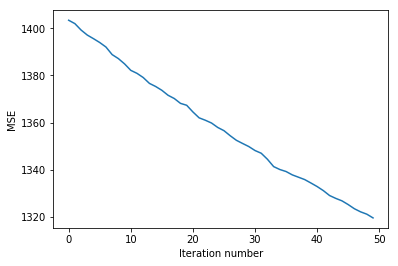

In [33]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[:50])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

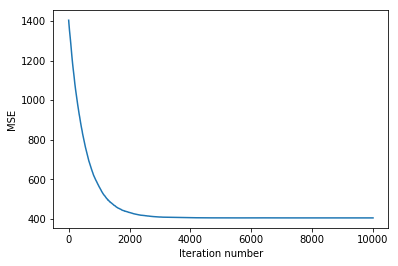

In [34]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

# Mini-batch gradient descent

Попытка сделать через матрицы, а не через цикл

Функция для шага:
$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x^{T} \times (w^{T} \times x - y)^{T}}}$

In [36]:
def mini_batch_gradient_step(X, y, w, batch_size, train_ind, eta=0.01):
    l = len(y)

    i = 0
    x_k = np.zeros((batch_size, 4), dtype='float64')
    y_k = np.zeros(batch_size, dtype='float64')

    for i in range(batch_size - 1):
        x_k[i] = X.values[train_ind[i]]
        y_k[i] = y.values[train_ind[i]]

    return w + 2 * eta / l * np.dot(x_k.T, (y_k - np.dot(w.T, x_k.T).T))

In [37]:
def mini_batch_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4, batch_size = 100,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors_mini_batch = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(low=0, high=X.shape[0], size=batch_size)
        # обновление весов
        new_w = mini_batch_gradient_step(X, y, w, batch_size, random_ind, eta=eta)
        
        iter_num += 1
        
        weight_dist = np.linalg.norm(new_w - w)
        print(weight_dist, min_weight_dist)
        print(iter_num)
        print('\n')
        
        errors_mini_batch.append(mserror(y, linear_prediction(X, new_w)))
        w = new_w
    
    return w, errors_mini_batch

In [ ]:
%%time
mini_batch_weights, mbatch_errors_by_iter = mini_batch_gradient_descent(X, y, np.zeros(4),
                                                                        max_iter = 1e4, batch_size = 10, seed=27)
print('\n')
print(mini_batch_weights)

0.035145932214846805 1e-08
1


0.02828749006603924 1e-08
2


0.04616434544245633 1e-08
3


0.0435816136087563 1e-08
4


0.030335438263138576 1e-08
5


0.036515446932444476 1e-08
6


0.03692376591512675 1e-08
7


0.06818797998083881 1e-08
8


0.030391873347827194 1e-08
9


0.03765564903176164 1e-08
10


0.04978638410377277 1e-08
11


0.030012009317464998 1e-08
12


0.03759649310411794 1e-08
13


0.04537079390671186 1e-08
14


0.023100392767859572 1e-08
15


0.02791576297916331 1e-08
16


0.037564193351912176 1e-08
17


0.03322280596041879 1e-08
18


0.03781220521063367 1e-08
19


0.023538974720504858 1e-08
20


0.0566771374280012 1e-08
21


0.0489286374822643 1e-08
22


0.01980185684965919 1e-08
23


0.034566830133017076 1e-08
24


0.03700233973780178 1e-08
25


0.028633584609616805 1e-08
26


0.03916947527761358 1e-08
27


0.038360099047311795 1e-08
28


0.023763626933156274 1e-08
29


0.022140841410454776 1e-08
30


0.03298947699140375 1e-08
31


0.030598820013341098 1e-08
32


0.0506

0.03774151806852294 1e-08
268


0.026468213107116497 1e-08
269


0.030080565925239805 1e-08
270


0.03734687310200989 1e-08
271


0.03222063667545513 1e-08
272


0.029377754951047493 1e-08
273


0.02551943309884615 1e-08
274


0.027231601229077116 1e-08
275


0.030097725120169148 1e-08
276


0.008615215510735004 1e-08
277


0.027006008272844138 1e-08
278


0.03344411648645253 1e-08
279


0.03763369619758221 1e-08
280


0.025918888770858073 1e-08
281


0.02031404479001377 1e-08
282


0.022818378041709768 1e-08
283


0.019959942024939344 1e-08
284


0.039448485026587515 1e-08
285


0.01968903412028127 1e-08
286


0.02995501924847419 1e-08
287


0.037660232157317286 1e-08
288


0.02679927448634225 1e-08
289


0.01868178566932982 1e-08
290


0.02091707924783144 1e-08
291


0.022533899735969712 1e-08
292


0.038127946054478654 1e-08
293


0.015880579004629036 1e-08
294


0.006677475285658277 1e-08
295


0.028153873359658483 1e-08
296


0.016749818856434243 1e-08
297


0.03079791524567634 1e

0.011056556478146554 1e-08
551


0.022217403896641192 1e-08
552


0.01547009984766479 1e-08
553


0.019193399499535302 1e-08
554


0.014855793922655363 1e-08
555


0.019191143631946142 1e-08
556


0.03546870352235163 1e-08
557


0.014629718890786417 1e-08
558


0.02135724495077146 1e-08
559


0.0217263285856139 1e-08
560


0.03472855755903488 1e-08
561


0.028729822839279988 1e-08
562


0.03152646788885012 1e-08
563


0.02707013779245775 1e-08
564


0.019259214363233617 1e-08
565


0.020583529618470174 1e-08
566


0.03076389461316258 1e-08
567


0.01748308832571611 1e-08
568


0.023003344155106752 1e-08
569


0.02452806149123036 1e-08
570


0.016640628356295876 1e-08
571


0.01512894362641594 1e-08
572


0.017769203166149845 1e-08
573


0.016079402372950868 1e-08
574


0.02602861714387507 1e-08
575


0.01466196468632153 1e-08
576


0.0072989304790569256 1e-08
577


0.02759477991292053 1e-08
578


0.014871548889811678 1e-08
579


0.03053635298723842 1e-08
580


0.023242138920365654 1e-0

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

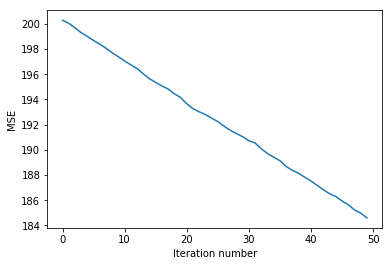

In [131]:
%pylab inline
plot(range(50), mbatch_errors_by_iter[:50])
xlabel('Iteration number')
ylabel('MSE')

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'MSE')

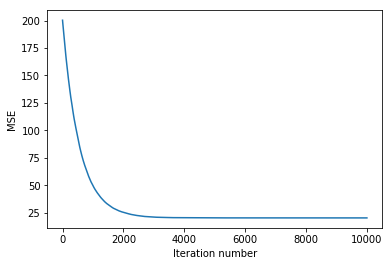

In [132]:
%pylab inline
plot(range(len(mbatch_errors_by_iter)), mbatch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

ПОЧЕМУ ЭТА ХЕРНЯ УХОДИТ В 25 И ОСТАНАВЛИВАЕТСЯ?

# Попытка в Momentum (ОСТАЛОСЬ ЧУТЬ - ЧУТЬ ДОПИЛИТЬ)

In [133]:
def backward(model, xs, hs, errs):
    """xs, hs, errs contain all informations (input, hidden state, error) of all data in the minibatch"""
    # errs is the gradients of output layer for the minibatch
    dW2 = hs.T @ errs

    # Get gradient of hidden layer
    dh = errs @ model['W2'].T
    dh[hs <= 0] = 0

    dW1 = xs.T @ dh

    return dict(W1=dW1, W2=dW2)


In [134]:
def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y = shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

In [135]:
def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)

        # Create probability distribution of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of minibatch
        # x: input
        # h: hidden state
        # err: gradient of output layer
        xs.append(x)
        hs.append(h)
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs), np.array(errs))

In [146]:
def momentum(model, X_train, y_train, minibatch_size):
    model.tolist()
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]

    return model

In [144]:
def sgd(model, X_train, y_train, minibatch_size):
    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            model[layer] += alpha * grad[layer]

    return model

In [147]:
model = momentum(np.zeros(4), X, y, 100)

ValueError: can only convert an array of size 1 to a Python scalar

# Применение алгоритмов (работает, довольно красиво, юзал tenserflow)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
__________

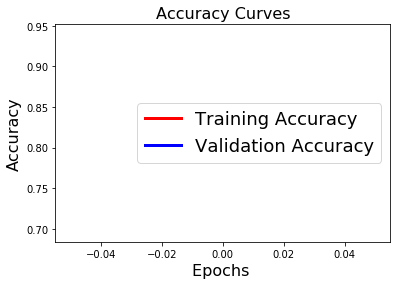

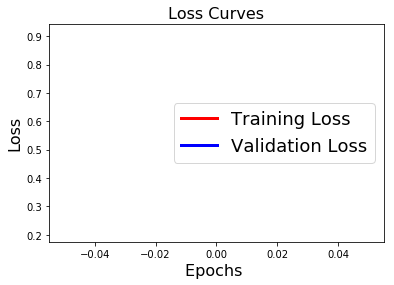

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [158]:
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.utils import np_utils
import os
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


def plot_loss_accuracy(history):
    plt.figure()
    epochs = range(len(history.epoch))
    plt.plot(epochs, history.history['acc'], 'r', linewidth=3.0)
    plt.plot(epochs,history.history['val_acc'], 'b', linewidth=3.0)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    
    plt.figure()
    plt.plot(epochs, history.history['loss'], 'r', linewidth=3.0)
    plt.plot(epochs,history.history['val_loss'], 'b', linewidth=3.0)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
    
    plt.show()

np.random.seed(100)

digit_train =  pd.read_csv("./train.csv")
digit_train.shape
#digit_train.info()

X_train = digit_train.iloc[:,1:].values.astype('float32')/255.0
##As we need images to be feeded to the CNN model , we are converting features to images
X_train_images=X_train.reshape(X_train.shape[0],28,28,1)

y_train = np_utils.to_categorical(digit_train["label"])

random_seed = 2
X_train_images, X_val, y_train, Y_val = train_test_split(X_train_images, y_train, test_size = 0.1, random_state=random_seed)

img_width, img_height = 28, 28

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)
    
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape,padding = 'Same'))
model.add(Conv2D(32, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10,  activation='softmax'))
print(model.summary())

model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_images)

epochs = 1 ## change this to 20
batchsize = 20
X_train_images.shape
# Fit the model
history = model.fit_generator(datagen.flow(X_train_images,y_train, batch_size=batchsize),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train_images.shape[0] // batchsize)

#history = model.fit(x=X_train_images, y=y_train, verbose=1, epochs=epochs, batch_size=batchsize, validation_split=0.2)
#print(model.get_weights())

historydf = pd.DataFrame(history.history, index=history.epoch)
plot_loss_accuracy(history)

digit_test = pd.read_csv("./test.csv")
digit_test.shape
digit_test.info()

X_test = digit_test.values.astype('float32')/255.0
X_test_images=X_test.reshape(X_test.shape[0],28,28,1)

pred = model.predict_classes(X_test_images)
submissions=pd.DataFrame({"ImageId": list(range(1,len(pred)+1)),
                         "Label": pred})
submissions.to_csv("submission.csv", index=False, header=True)